<a href="https://colab.research.google.com/github/Claudia-Cabrera/machine-learning-for-business-analytics/blob/main/Cabrera_BAN6025_ForecastingExamPt2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import scipy as sp
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_predict
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima.model import ARIMAResults
from scipy.signal import detrend

In [ ]:
# mount to google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import mt_steel.csv data
steel_df = pd.read_csv('/content/drive/MyDrive/Machine Learning/mt_steel.csv')
steel_df.head()

,EXPORT,YEAR
0,3.89,1937
1,2.41,1938
2,2.80,1939
3,8.72,1940
4,7.12,1941


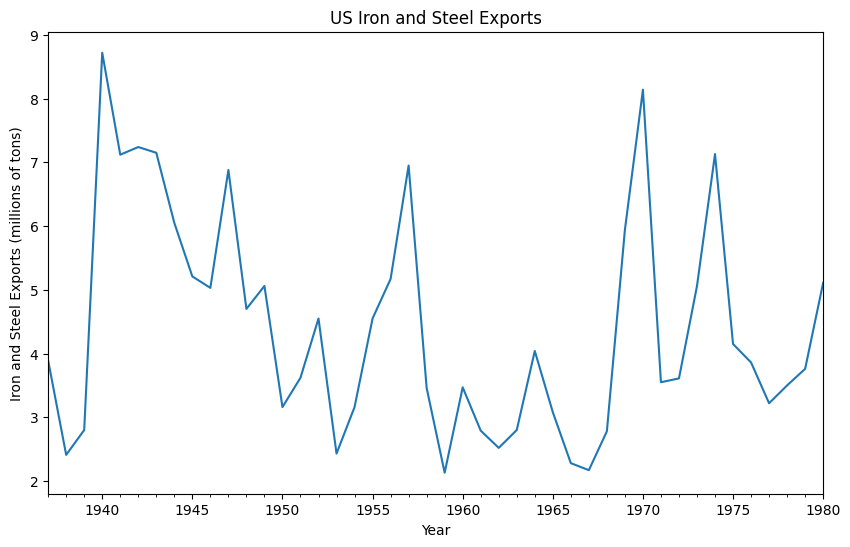

In [ ]:
# convert year column to date type variable
steel_df['YEAR'] = pd.to_datetime(steel_df['YEAR'], format='%Y')

# create indexed series
steel_ts = pd.Series(steel_df['EXPORT'].values, index=steel_df['YEAR'])
steel_ts.index.freq = 'YS'

# create time plot of the data
plt.figure(figsize=(10, 6))
steel_ts.plot()
plt.title("US Iron and Steel Exports")
plt.xlabel("Year")
plt.ylabel("Iron and Steel Exports (millions of tons)")
plt.show()

In [ ]:
# Ljung-Box Test using 5 lags
EXPORTS = steel_df[['EXPORT']]
sm.stats.acorr_ljungbox(EXPORTS, lags=[5], return_df=True)

,lb_stat,lb_pvalue
5,12.151048,0.032776


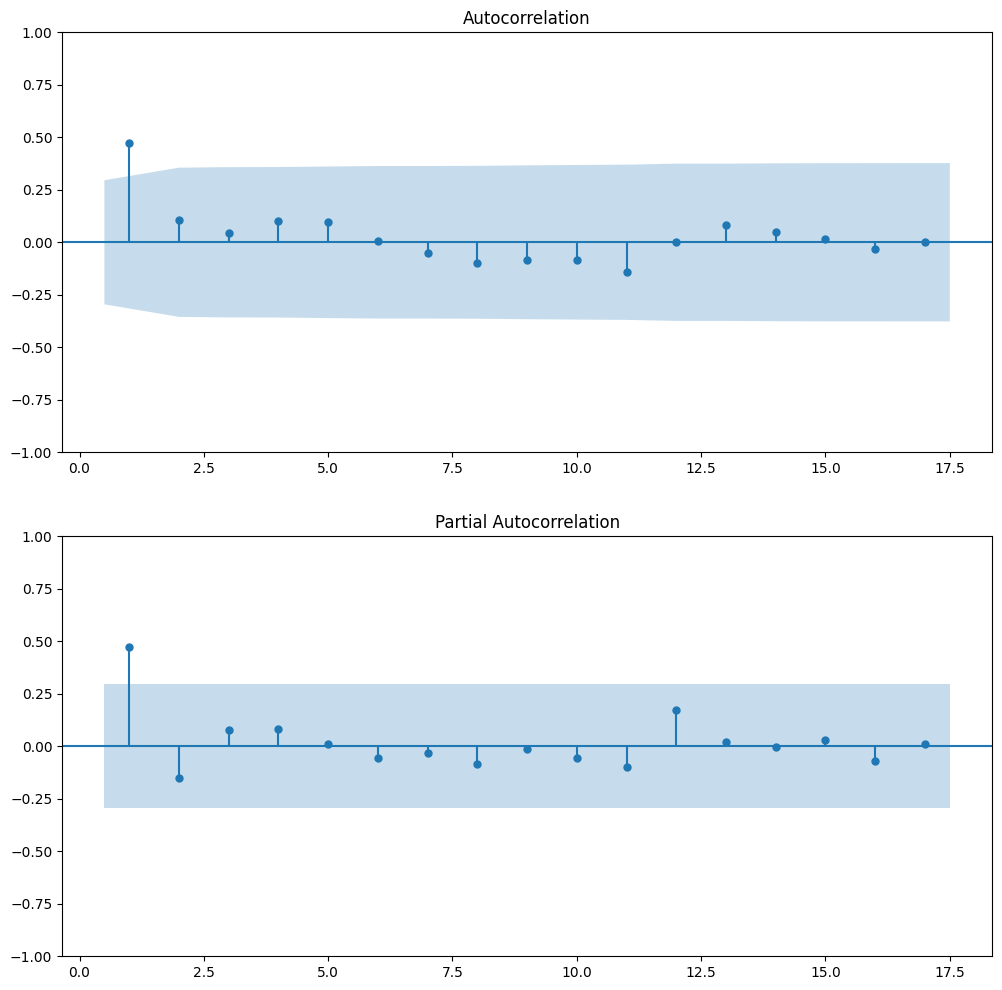

In [ ]:
# Plot the ACF & PACF for the series
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(steel_ts, ax=ax1, zero=False)
plot_pacf(steel_ts, ax=ax2, zero=False)
plt.show()

In [ ]:
# ADF Test (single-mean version)
adfuller(steel_ts, regression='c')

(-3.8376521789007034,
 0.00254474237765945,
 1,
 42,
 {'1%': -3.596635636000432,
  '5%': -2.933297331821618,
  '10%': -2.6049909750566895},
 116.78753840925029)

# ARIMA Models


## **Model 1:**
ARIMA(1,0,0)

In [ ]:
# fit ARIMA(1,0,0) model to the data
fit_AR1 = ARIMA(steel_ts, order=(1,0,0)).fit()

# Summary of the ARIMA model
print(fit_AR1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   44
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -81.186
Date:                Wed, 09 Oct 2024   AIC                            168.371
Time:                        18:52:08   BIC                            173.724
Sample:                    01-01-1937   HQIC                           170.356
                         - 01-01-1980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4213      0.554      7.975      0.000       3.335       5.508
ar.L1          0.4642      0.159      2.919      0.004       0.152       0.776
sigma2         2.3323      0.577      4.044      0.0

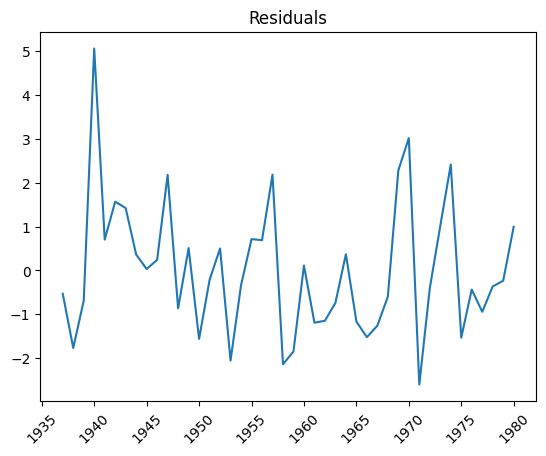

In [ ]:
# Examine residuals from the model
residuals = fit_AR1.resid
plt.plot(residuals)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

#Generate the predicted values for the series
pred_units = fit_AR1.get_prediction()
print(pred_units)

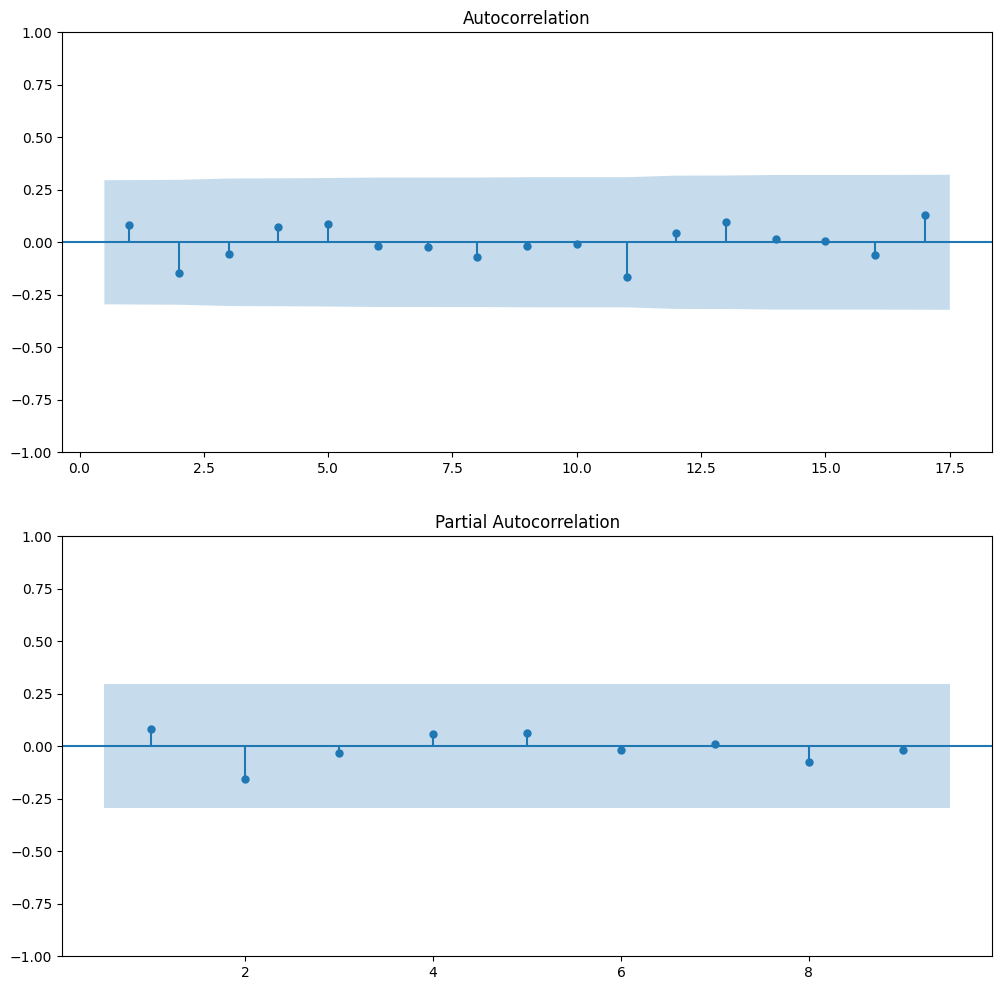

In [ ]:
# Plot ACF and PACF for residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals, ax=ax1, zero=False)
plot_pacf(residuals, ax=ax2, zero=False, lags=9)
plt.show()

In [ ]:
#execute the Ljung Box test on the residuals

sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,2.509502,0.990737


In [ ]:
# convert to data frame
predicted_mean = pred_units.predicted_mean
conf_int = pred_units.conf_int()

prediction_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'lower_bound': conf_int.iloc[:, 0],
    'upper_bound': conf_int.iloc[:, 1]
})
prediction_df.head()

,predicted_mean,lower_bound,upper_bound
YEAR,,,
1937-01-01,4.421282,1.041937,7.800627
1938-01-01,4.174680,1.181428,7.167932
1939-01-01,3.487717,0.494465,6.480969
1940-01-01,3.668741,0.675489,6.661993
1941-01-01,6.416592,3.423340,9.409844


In [ ]:
# add back actuals --
prediction_df = pd.concat([prediction_df,steel_ts.to_frame(name='EXPORTS')],axis=1)
prediction_df.head()

,predicted_mean,lower_bound,upper_bound,EXPORTS
YEAR,,,,
1937-01-01,4.421282,1.041937,7.800627,3.89
1938-01-01,4.174680,1.181428,7.167932,2.41
1939-01-01,3.487717,0.494465,6.480969,2.80
1940-01-01,3.668741,0.675489,6.661993,8.72
1941-01-01,6.416592,3.423340,9.409844,7.12


In [ ]:
# calc error
errors = prediction_df['EXPORTS'] - prediction_df['predicted_mean']
# absolue value of error
errors_abs = errors.abs()
# -- mape --
mape = (errors_abs/prediction_df['EXPORTS'].abs()).mean()
# -- rmse
rmse = (errors**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape:.3%}')
print(f'RMSE = {rmse:,.3f}')


MAPE = 29.548%
RMSE = 1.528


## **Model 2**
ARIMA(1,1,0)

In [ ]:
# fit ARIMA(1,1,0) model to the data
fit_AR2 = ARIMA(steel_ts, order=(1,1,0)).fit()

# Summary of the ARIMA model
print(fit_AR2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   44
Model:                 ARIMA(1, 1, 0)   Log Likelihood                 -85.719
Date:                Wed, 09 Oct 2024   AIC                            175.438
Time:                        18:52:09   BIC                            178.960
Sample:                    01-01-1937   HQIC                           176.737
                         - 01-01-1980                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1526      0.171     -0.892      0.372      -0.488       0.183
sigma2         3.1534      0.495      6.371      0.000       2.183       4.124
Ljung-Box (L1) (Q):                   0.12   Jarque-

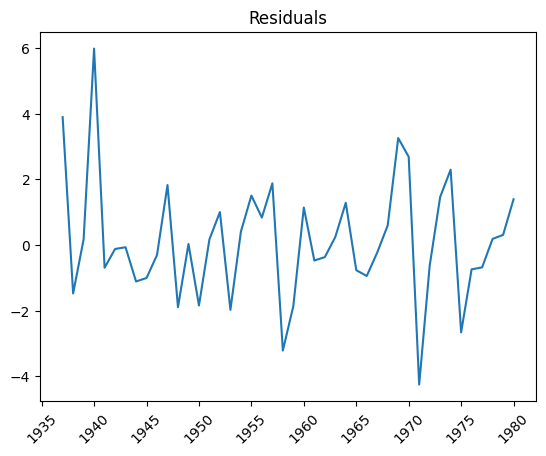

In [ ]:
# Examine residuals from the model
residuals = fit_AR2.resid
plt.plot(residuals)
plt.title('Residuals')
plt.xticks(rotation=45)
plt.show()

#Generate the predicted values for the series
pred_units = fit_AR2.get_prediction()
print(pred_units)

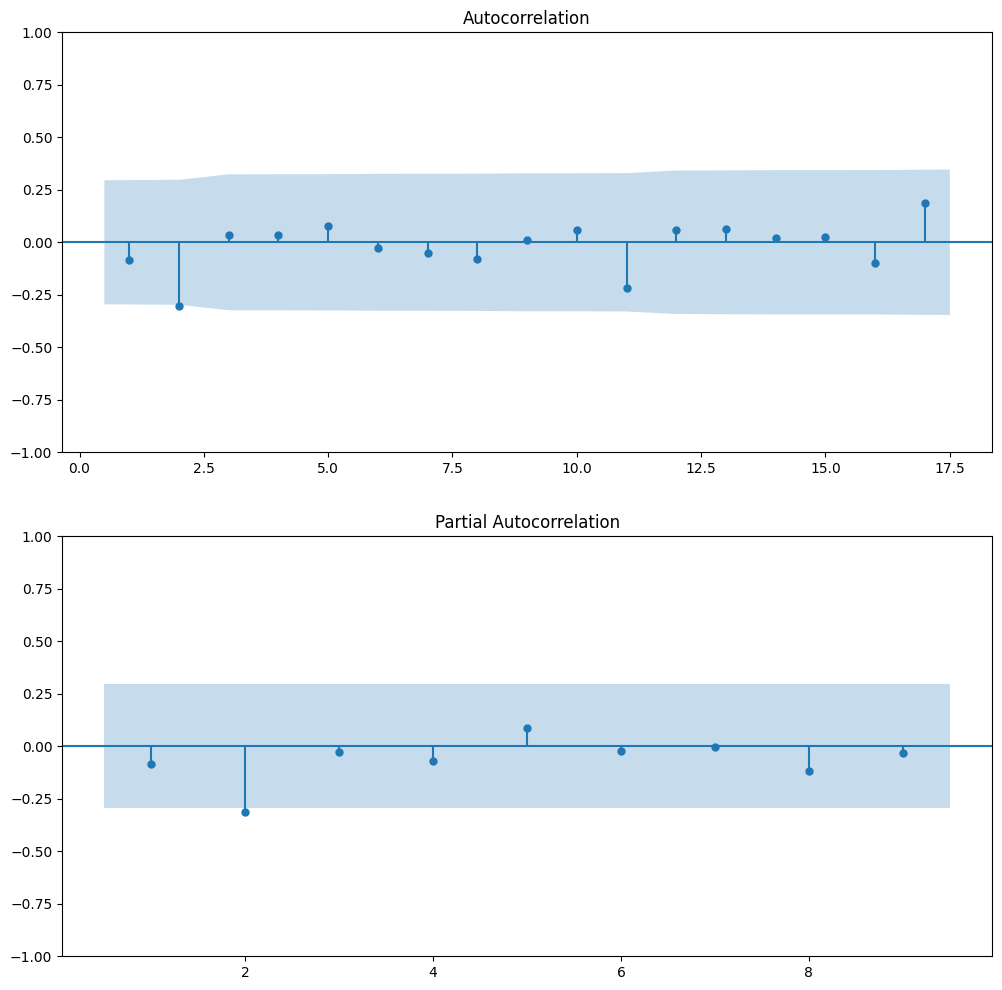

In [ ]:
# Plot ACF and PACF for residuals

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
plot_acf(residuals, ax=ax1, zero=False)
plot_pacf(residuals, ax=ax2, zero=False, lags=9)
plt.show()

In [ ]:
#execute the Ljung Box test on the residuals

sm.stats.acorr_ljungbox(residuals, lags=[10], return_df=True)

,lb_stat,lb_pvalue
10,6.019183,0.813649


In [ ]:
# convert to data frame
predicted_mean = pred_units.predicted_mean
conf_int = pred_units.conf_int()

prediction_df = pd.DataFrame({
    'predicted_mean': predicted_mean,
    'lower_bound': conf_int.iloc[:, 0],
    'upper_bound': conf_int.iloc[:, 1]
})
prediction_df.head()

,predicted_mean,lower_bound,upper_bound
YEAR,,,
1937-01-01,0.000000,-1959.967149,1959.967149
1938-01-01,3.889998,0.368248,7.411748
1939-01-01,2.635877,-0.844615,6.116370
1940-01-01,2.740478,-0.740014,6.220971
1941-01-01,7.816490,4.335998,11.296983


In [ ]:
# add back actuals --
prediction_df = pd.concat([prediction_df,steel_ts.to_frame(name='EXPORTS')],axis=1)
prediction_df.head()

,predicted_mean,lower_bound,upper_bound,EXPORTS
YEAR,,,,
1937-01-01,0.000000,-1959.967149,1959.967149,3.89
1938-01-01,3.889998,0.368248,7.411748,2.41
1939-01-01,2.635877,-0.844615,6.116370,2.80
1940-01-01,2.740478,-0.740014,6.220971,8.72
1941-01-01,7.816490,4.335998,11.296983,7.12


In [ ]:
# calc error
errors = prediction_df['EXPORTS'] - prediction_df['predicted_mean']
# absolue value of error
errors_abs = errors.abs()
# -- mape --
mape = (errors_abs/prediction_df['EXPORTS'].abs()).mean()
# -- rmse
rmse = (errors**2).mean()**0.5
# -- print it out
print(f'MAPE = {mape:.3%}')
print(f'RMSE = {rmse:,.3f}')


MAPE = 32.510%
RMSE = 1.851


# Forecasted Iron & Steel Exports for 1981, 1982, and 1983
Using ARIMA Model 1: **```
ARIMA(1,0,0)
```**

In [ ]:
# Generate the forecast for the next 3 years
forecast = fit_AR1.get_forecast(steps=3)
mean_forecast = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create a DataFrame with forecasted values and confidence intervals
forecast_df = pd.DataFrame({
    'Forecasted_EXPORTS': mean_forecast,
    'Lower_Bound': confidence_intervals.iloc[:, 0],
    'Upper_Bound': confidence_intervals.iloc[:, 1]
})

forecast_df

,Forecasted_EXPORTS,Lower_Bound,Upper_Bound
1981-01-01,4.740960,1.747708,7.734212
1982-01-01,4.569665,1.269683,7.869647
1983-01-01,4.490156,1.127752,7.852560


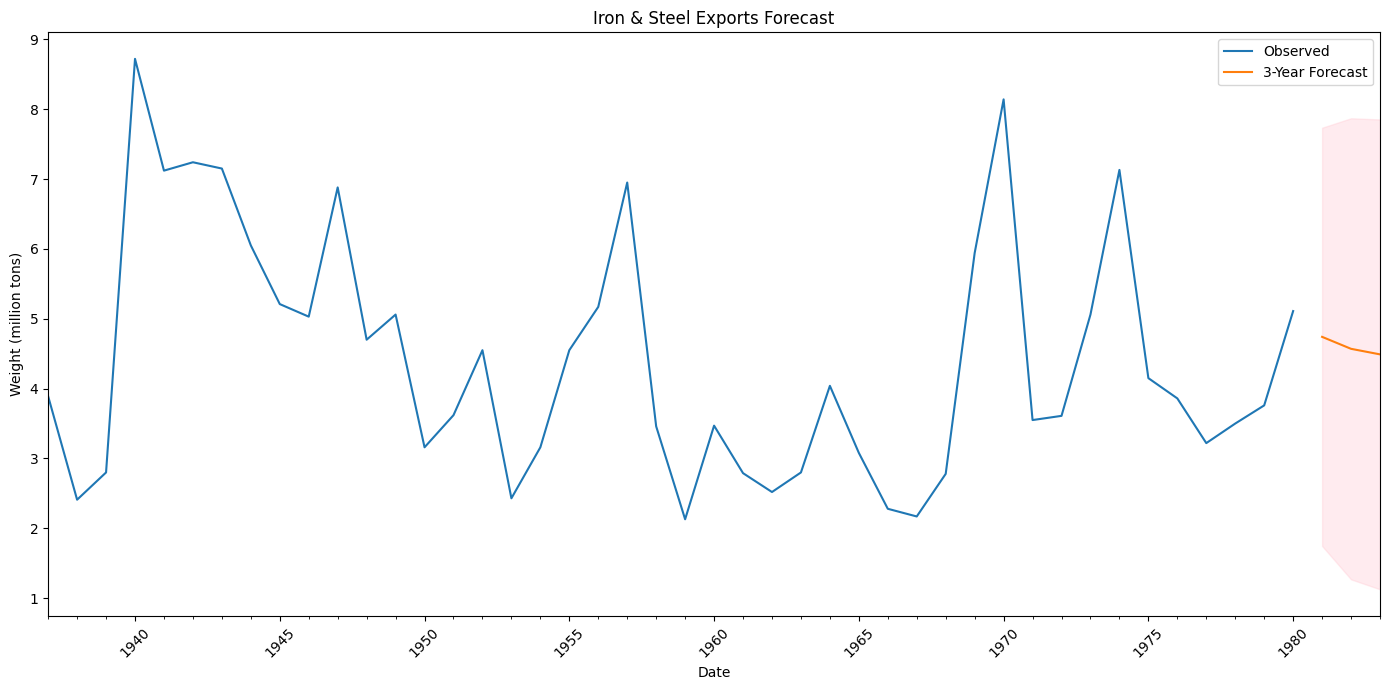

In [ ]:
# Plot forecast
plt.figure(figsize=(14, 7))
steel_ts.plot(label='Observed', legend=True)
mean_forecast.plot(label='3-Year Forecast', legend=True)
plt.fill_between(confidence_intervals.index,
                 confidence_intervals.iloc[:, 0],
                 confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Iron & Steel Exports Forecast")
plt.xlabel("Date")
plt.ylabel("Weight (million tons)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()